In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
test_classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=1280),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1280, out_features=num_classes),
)

In [9]:
model.classifier = test_classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1280, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1280, out_features=7, bias=True)
)

In [10]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

dataset_str = 'cropped_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'
#dataset_str = 'cropped_rotated_processed_images_3'
#dataset_str = 'cropped_processed_images_1'

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [11]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [12]:
model = model.to(device)

In [13]:
results_dir = 'results/'

In [14]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [15]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 6 / 10 with accuracy 60.00
Got 11 / 20 with accuracy 55.00
Got 17 / 30 with accuracy 56.67
Got 22 / 40 with accuracy 55.00
Got 27 / 50 with accuracy 54.00
Got 31 / 60 with accuracy 51.67
Got 36 / 70 with accuracy 51.43
Got 40 / 80 with accuracy 50.00
Got 46 / 90 with accuracy 51.11
Got 51 / 100 with accuracy 51.00
Got 56 / 110 with accuracy 50.91
Got 65 / 120 with accuracy 54.17
Got 71 / 130 with accuracy 54.62
Got 79 / 140 with accuracy 56.43
Got 82 / 150 with accuracy 54.67
Got 87 / 160 with accuracy 54.37
Got 93 / 170 with accuracy 54.71
Got 97 / 180 with accuracy 53.89
Got 101 / 190 with accuracy 53.16
Got 105 / 196 with accuracy 53.57
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 67 / 80 with accuracy 83.75
Got 75 / 90 with accuracy 83.33
Got 83 / 100 with accuracy 83.00
Got 91 / 110 with accuracy 82.73
Got 99 / 120 with accuracy 82.50
Got 106 / 130 with accuracy 81.54
Got 116 / 140 with accuracy 82.86
Got 123 / 150 with accuracy 82.00
Got 131 / 160 with accuracy 81.88
Got 139 / 170 with accuracy 81.76
Got 147 / 180 with accuracy 81.67
Got 154 / 190 with accuracy 81.05
Got 159 / 196 with accuracy 81.12
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 15 / 20 with accuracy 75.00
Got 23 / 30 with accuracy 76.67
Got 28 / 40 with accuracy 70.00
Got 35 / 50 with accuracy 70.00
Got 45 / 60 with accuracy 75.00
Got 53 / 70 with accuracy 75.71
Got 61 / 80 with accuracy 76.25
Got 70 / 90 with accuracy 77.78
Got 78 / 100 with accuracy 78.00
Got 85 / 110 with accuracy 77.27
Got 93 / 120 with accuracy 77.50
Got 100 / 130 with accuracy 76.92
Got 108 / 140 with accuracy 77.14
Got 116 / 150 with accuracy 77.33
Got 125 / 160 with accuracy 78.12
Got 131 / 170 with accuracy 77.06
Got 138 / 180 with accuracy 76.67
Got 145 / 190 with accuracy 76.32
Got 150 / 196 with accuracy 76.53
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 5 / 10 with accuracy 50.00
Got 14 / 20 with accuracy 70.00
Got 20 / 30 with accuracy 66.67
Got 26 / 40 with accuracy 65.00
Got 33 / 50 with accuracy 66.00
Got 41 / 60 with accuracy 68.33
Got 48 / 70 with accuracy 68.57
Got 54 / 80 with accuracy 67.50
Got 63 / 90 with accuracy 70.00
Got 72 / 100 with accuracy 72.00
Got 79 / 110 with accuracy 71.82
Got 85 / 120 with accuracy 70.83
Got 92 / 130 with accuracy 70.77
Got 96 / 140 with accuracy 68.57
Got 103 / 150 with accuracy 68.67
Got 109 / 160 with accuracy 68.12
Got 117 / 170 with accuracy 68.82
Got 123 / 180 with accuracy 68.33
Got 132 / 190 with accuracy 69.47
Got 135 / 196 with accuracy 68.88
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 56 / 60 with accuracy 93.33
Got 64 / 70 with accuracy 91.43
Got 72 / 80 with accuracy 90.00
Got 81 / 90 with accuracy 90.00
Got 89 / 100 with accuracy 89.00
Got 99 / 110 with accuracy 90.00
Got 108 / 120 with accuracy 90.00
Got 117 / 130 with accuracy 90.00
Got 124 / 140 with accuracy 88.57
Got 132 / 150 with accuracy 88.00
Got 141 / 160 with accuracy 88.12
Got 149 / 170 with accuracy 87.65
Got 159 / 180 with accuracy 88.33
Got 168 / 190 with accuracy 88.42
Got 173 / 196 with accuracy 88.27
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 18 / 20 with accuracy 90.00
Got 26 / 30 with accuracy 86.67
Got 35 / 40 with accuracy 87.50
Got 42 / 50 with accuracy 84.00
Got 51 / 60 with accuracy 85.00
Got 60 / 70 with accuracy 85.71
Got 69 / 80 with accuracy 86.25
Got 79 / 90 with accuracy 87.78
Got 89 / 100 with accuracy 89.00
Got 98 / 110 with accuracy 89.09
Got 106 / 120 with accuracy 88.33
Got 113 / 130 with accuracy 86.92
Got 123 / 140 with accuracy 87.86
Got 133 / 150 with accuracy 88.67
Got 143 / 160 with accuracy 89.38
Got 151 / 170 with accuracy 88.82
Got 157 / 180 with accuracy 87.22
Got 165 / 190 with accuracy 86.84
Got 169 / 196 with accuracy 86.22
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 17 / 20 with accuracy 85.00
Got 26 / 30 with accuracy 86.67
Got 35 / 40 with accuracy 87.50
Got 44 / 50 with accuracy 88.00
Got 53 / 60 with accuracy 88.33
Got 63 / 70 with accuracy 90.00
Got 71 / 80 with accuracy 88.75
Got 81 / 90 with accuracy 90.00
Got 90 / 100 with accuracy 90.00
Got 99 / 110 with accuracy 90.00
Got 106 / 120 with accuracy 88.33
Got 113 / 130 with accuracy 86.92
Got 120 / 140 with accuracy 85.71
Got 128 / 150 with accuracy 85.33
Got 137 / 160 with accuracy 85.62
Got 146 / 170 with accuracy 85.88
Got 156 / 180 with accuracy 86.67
Got 165 / 190 with accuracy 86.84
Got 170 / 196 with accuracy 86.73
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 25 / 30 with accuracy 83.33
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 51 / 60 with accuracy 85.00
Got 59 / 70 with accuracy 84.29
Got 69 / 80 with accuracy 86.25
Got 78 / 90 with accuracy 86.67
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 105 / 120 with accuracy 87.50
Got 114 / 130 with accuracy 87.69
Got 123 / 140 with accuracy 87.86
Got 131 / 150 with accuracy 87.33
Got 138 / 160 with accuracy 86.25
Got 146 / 170 with accuracy 85.88
Got 154 / 180 with accuracy 85.56
Got 163 / 190 with accuracy 85.79
Got 168 / 196 with accuracy 85.71
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 31 / 40 with accuracy 77.50
Got 40 / 50 with accuracy 80.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 66 / 80 with accuracy 82.50
Got 73 / 90 with accuracy 81.11
Got 83 / 100 with accuracy 83.00
Got 92 / 110 with accuracy 83.64
Got 100 / 120 with accuracy 83.33
Got 109 / 130 with accuracy 83.85
Got 118 / 140 with accuracy 84.29
Got 128 / 150 with accuracy 85.33
Got 136 / 160 with accuracy 85.00
Got 144 / 170 with accuracy 84.71
Got 153 / 180 with accuracy 85.00
Got 161 / 190 with accuracy 84.74
Got 166 / 196 with accuracy 84.69
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 16 / 20 with accuracy 80.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 42 / 50 with accuracy 84.00
Got 52 / 60 with accuracy 86.67
Got 61 / 70 with accuracy 87.14
Got 71 / 80 with accuracy 88.75
Got 80 / 90 with accuracy 88.89
Got 88 / 100 with accuracy 88.00
Got 97 / 110 with accuracy 88.18
Got 106 / 120 with accuracy 88.33
Got 112 / 130 with accuracy 86.15
Got 120 / 140 with accuracy 85.71
Got 128 / 150 with accuracy 85.33
Got 136 / 160 with accuracy 85.00
Got 143 / 170 with accuracy 84.12
Got 152 / 180 with accuracy 84.44
Got 160 / 190 with accuracy 84.21
Got 166 / 196 with accuracy 84.69
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 6 / 10 with accuracy 60.00
Got 16 / 20 with accuracy 80.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 43 / 50 with accuracy 86.00
Got 51 / 60 with accuracy 85.00
Got 59 / 70 with accuracy 84.29
Got 68 / 80 with accuracy 85.00
Got 77 / 90 with accuracy 85.56
Got 86 / 100 with accuracy 86.00
Got 93 / 110 with accuracy 84.55
Got 102 / 120 with accuracy 85.00
Got 112 / 130 with accuracy 86.15
Got 122 / 140 with accuracy 87.14
Got 131 / 150 with accuracy 87.33
Got 139 / 160 with accuracy 86.88
Got 147 / 170 with accuracy 86.47
Got 157 / 180 with accuracy 87.22
Got 167 / 190 with accuracy 87.89
Got 172 / 196 with accuracy 87.76
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 16 / 20 with accuracy 80.00
Got 24 / 30 with accuracy 80.00
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 50 / 60 with accuracy 83.33
Got 58 / 70 with accuracy 82.86
Got 68 / 80 with accuracy 85.00
Got 77 / 90 with accuracy 85.56
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 100 / 120 with accuracy 83.33
Got 109 / 130 with accuracy 83.85
Got 119 / 140 with accuracy 85.00
Got 128 / 150 with accuracy 85.33
Got 138 / 160 with accuracy 86.25
Got 148 / 170 with accuracy 87.06
Got 156 / 180 with accuracy 86.67
Got 165 / 190 with accuracy 86.84
Got 171 / 196 with accuracy 87.24
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 28 / 30 with accuracy 93.33
Got 38 / 40 with accuracy 95.00
Got 45 / 50 with accuracy 90.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 72 / 80 with accuracy 90.00
Got 80 / 90 with accuracy 88.89
Got 88 / 100 with accuracy 88.00
Got 98 / 110 with accuracy 89.09
Got 108 / 120 with accuracy 90.00
Got 117 / 130 with accuracy 90.00
Got 126 / 140 with accuracy 90.00
Got 135 / 150 with accuracy 90.00
Got 144 / 160 with accuracy 90.00
Got 153 / 170 with accuracy 90.00
Got 163 / 180 with accuracy 90.56
Got 171 / 190 with accuracy 90.00
Got 176 / 196 with accuracy 89.80
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 35 / 40 with accuracy 87.50
Got 43 / 50 with accuracy 86.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 70 / 80 with accuracy 87.50
Got 80 / 90 with accuracy 88.89
Got 89 / 100 with accuracy 89.00
Got 98 / 110 with accuracy 89.09
Got 107 / 120 with accuracy 89.17
Got 116 / 130 with accuracy 89.23
Got 126 / 140 with accuracy 90.00
Got 135 / 150 with accuracy 90.00
Got 143 / 160 with accuracy 89.38
Got 150 / 170 with accuracy 88.24
Got 159 / 180 with accuracy 88.33
Got 169 / 190 with accuracy 88.95
Got 175 / 196 with accuracy 89.29
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 15 / 20 with accuracy 75.00
Got 23 / 30 with accuracy 76.67
Got 32 / 40 with accuracy 80.00
Got 41 / 50 with accuracy 82.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 67 / 80 with accuracy 83.75
Got 77 / 90 with accuracy 85.56
Got 87 / 100 with accuracy 87.00
Got 97 / 110 with accuracy 88.18
Got 106 / 120 with accuracy 88.33
Got 115 / 130 with accuracy 88.46
Got 124 / 140 with accuracy 88.57
Got 132 / 150 with accuracy 88.00
Got 140 / 160 with accuracy 87.50
Got 149 / 170 with accuracy 87.65
Got 159 / 180 with accuracy 88.33
Got 169 / 190 with accuracy 88.95
Got 175 / 196 with accuracy 89.29
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 16 / 20 with accuracy 80.00
Got 24 / 30 with accuracy 80.00
Got 33 / 40 with accuracy 82.50
Got 42 / 50 with accuracy 84.00
Got 50 / 60 with accuracy 83.33
Got 58 / 70 with accuracy 82.86
Got 65 / 80 with accuracy 81.25
Got 74 / 90 with accuracy 82.22
Got 84 / 100 with accuracy 84.00
Got 93 / 110 with accuracy 84.55
Got 101 / 120 with accuracy 84.17
Got 109 / 130 with accuracy 83.85
Got 118 / 140 with accuracy 84.29
Got 125 / 150 with accuracy 83.33
Got 135 / 160 with accuracy 84.38
Got 145 / 170 with accuracy 85.29
Got 154 / 180 with accuracy 85.56
Got 162 / 190 with accuracy 85.26
Got 166 / 196 with accuracy 84.69
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 28 / 30 with accuracy 93.33
Got 38 / 40 with accuracy 95.00
Got 44 / 50 with accuracy 88.00
Got 51 / 60 with accuracy 85.00
Got 59 / 70 with accuracy 84.29
Got 69 / 80 with accuracy 86.25
Got 77 / 90 with accuracy 85.56
Got 85 / 100 with accuracy 85.00
Got 94 / 110 with accuracy 85.45
Got 101 / 120 with accuracy 84.17
Got 110 / 130 with accuracy 84.62
Got 119 / 140 with accuracy 85.00
Got 126 / 150 with accuracy 84.00
Got 134 / 160 with accuracy 83.75
Got 144 / 170 with accuracy 84.71
Got 152 / 180 with accuracy 84.44
Got 158 / 190 with accuracy 83.16
Got 163 / 196 with accuracy 83.16
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 44 / 50 with accuracy 88.00
Got 52 / 60 with accuracy 86.67
Got 60 / 70 with accuracy 85.71
Got 69 / 80 with accuracy 86.25
Got 79 / 90 with accuracy 87.78
Got 88 / 100 with accuracy 88.00
Got 96 / 110 with accuracy 87.27
Got 102 / 120 with accuracy 85.00
Got 108 / 130 with accuracy 83.08
Got 116 / 140 with accuracy 82.86
Got 123 / 150 with accuracy 82.00
Got 131 / 160 with accuracy 81.88
Got 141 / 170 with accuracy 82.94
Got 149 / 180 with accuracy 82.78
Got 156 / 190 with accuracy 82.11
Got 160 / 196 with accuracy 81.63
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 35 / 40 with accuracy 87.50
Got 44 / 50 with accuracy 88.00
Got 52 / 60 with accuracy 86.67
Got 61 / 70 with accuracy 87.14
Got 69 / 80 with accuracy 86.25
Got 79 / 90 with accuracy 87.78
Got 89 / 100 with accuracy 89.00
Got 96 / 110 with accuracy 87.27
Got 105 / 120 with accuracy 87.50
Got 114 / 130 with accuracy 87.69
Got 121 / 140 with accuracy 86.43
Got 130 / 150 with accuracy 86.67
Got 139 / 160 with accuracy 86.88
Got 149 / 170 with accuracy 87.65
Got 158 / 180 with accuracy 87.78
Got 166 / 190 with accuracy 87.37
Got 172 / 196 with accuracy 87.76
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 45 / 50 with accuracy 90.00
Got 55 / 60 with accuracy 91.67
Got 64 / 70 with accuracy 91.43
Got 71 / 80 with accuracy 88.75
Got 79 / 90 with accuracy 87.78
Got 86 / 100 with accuracy 86.00
Got 96 / 110 with accuracy 87.27
Got 105 / 120 with accuracy 87.50
Got 115 / 130 with accuracy 88.46
Got 124 / 140 with accuracy 88.57
Got 132 / 150 with accuracy 88.00
Got 140 / 160 with accuracy 87.50
Got 149 / 170 with accuracy 87.65
Got 157 / 180 with accuracy 87.22
Got 167 / 190 with accuracy 87.89
Got 173 / 196 with accuracy 88.27


In [16]:
csvfile.close()

In [17]:
best_acc

89.79591836734694

In [18]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [26]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [27]:
testloader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True, num_workers=0)

In [28]:
dataiter = iter(testloader)
x, y = next(dataiter)
scores = model(x)
predictions = scores.argmax(1)

In [29]:
predictions

tensor([5, 4, 0, 2, 3, 1, 0, 4, 1, 1, 1, 2, 1, 2, 5, 6, 2, 1, 2, 5, 2, 3, 3, 4,
        4, 2, 3, 2, 1, 3, 1, 0, 3, 0, 2, 3, 3, 3, 5, 4, 1, 0, 0, 1, 1, 5, 5, 0,
        6, 5, 0, 5, 1, 0, 5, 3, 1, 2, 4, 0, 3, 4, 4, 1, 5, 1, 5, 2, 5, 2, 6, 6,
        2, 3, 3, 1, 3, 4, 5, 0, 5, 5, 6, 2, 6, 6, 1, 2, 6, 0, 5, 1, 1, 6, 3, 6,
        1, 5, 0, 1, 5, 4, 0, 6, 1, 5, 1, 6, 1, 1, 2, 2, 3, 1, 1, 0, 4, 2, 0, 4,
        3, 3, 4, 5, 0, 1, 5, 2, 3, 2, 3, 0, 3, 0, 4, 0, 6, 2, 4, 4, 6, 3, 2, 2,
        1, 3, 1, 5, 6, 2, 5, 6, 1, 5, 3, 3, 0, 6, 1, 1, 1, 1, 0, 4, 3, 4, 1, 3,
        6, 1, 5, 4, 3, 3, 4, 4, 0, 0, 0, 0, 5, 2, 5, 5, 0, 1, 4, 3, 3, 3, 2, 0,
        3, 1, 3, 2])

In [30]:
y

tensor([5, 4, 0, 2, 3, 1, 0, 2, 1, 1, 1, 2, 1, 2, 5, 6, 2, 1, 2, 5, 6, 3, 3, 4,
        4, 2, 3, 5, 1, 3, 1, 4, 3, 3, 2, 3, 3, 0, 5, 4, 1, 0, 0, 1, 5, 5, 1, 0,
        6, 5, 4, 5, 1, 0, 5, 3, 1, 2, 4, 0, 3, 4, 4, 1, 5, 1, 5, 2, 5, 2, 6, 6,
        2, 3, 3, 1, 0, 4, 5, 0, 5, 5, 6, 2, 6, 6, 1, 2, 6, 0, 5, 1, 1, 6, 3, 6,
        6, 5, 4, 1, 5, 4, 0, 6, 1, 5, 1, 6, 1, 1, 2, 2, 3, 1, 1, 0, 4, 6, 4, 4,
        3, 3, 4, 5, 0, 1, 5, 2, 3, 2, 3, 0, 3, 0, 4, 0, 6, 2, 4, 4, 6, 3, 2, 2,
        1, 3, 1, 5, 6, 2, 5, 6, 1, 5, 3, 0, 0, 6, 1, 1, 1, 6, 0, 4, 3, 0, 1, 3,
        6, 1, 5, 4, 3, 3, 4, 4, 0, 3, 0, 4, 5, 2, 5, 5, 0, 1, 4, 3, 3, 3, 2, 4,
        3, 1, 3, 2])

In [31]:
import pandas as pd

In [32]:
df = pd.DataFrame({'predictions': predictions.cpu().numpy(), 'y_true': y.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,5,5
1,4,4
2,0,0
3,2,2
4,3,3
...,...,...
191,0,4
192,3,3
193,1,1
194,3,3


In [33]:
preds = df['predictions'].values
preds

array([5, 4, 0, 2, 3, 1, 0, 4, 1, 1, 1, 2, 1, 2, 5, 6, 2, 1, 2, 5, 2, 3,
       3, 4, 4, 2, 3, 2, 1, 3, 1, 0, 3, 0, 2, 3, 3, 3, 5, 4, 1, 0, 0, 1,
       1, 5, 5, 0, 6, 5, 0, 5, 1, 0, 5, 3, 1, 2, 4, 0, 3, 4, 4, 1, 5, 1,
       5, 2, 5, 2, 6, 6, 2, 3, 3, 1, 3, 4, 5, 0, 5, 5, 6, 2, 6, 6, 1, 2,
       6, 0, 5, 1, 1, 6, 3, 6, 1, 5, 0, 1, 5, 4, 0, 6, 1, 5, 1, 6, 1, 1,
       2, 2, 3, 1, 1, 0, 4, 2, 0, 4, 3, 3, 4, 5, 0, 1, 5, 2, 3, 2, 3, 0,
       3, 0, 4, 0, 6, 2, 4, 4, 6, 3, 2, 2, 1, 3, 1, 5, 6, 2, 5, 6, 1, 5,
       3, 3, 0, 6, 1, 1, 1, 1, 0, 4, 3, 4, 1, 3, 6, 1, 5, 4, 3, 3, 4, 4,
       0, 0, 0, 0, 5, 2, 5, 5, 0, 1, 4, 3, 3, 3, 2, 0, 3, 1, 3, 2],
      dtype=int64)

In [34]:
y_true = df['y_true'].values
y_true

array([5, 4, 0, 2, 3, 1, 0, 2, 1, 1, 1, 2, 1, 2, 5, 6, 2, 1, 2, 5, 6, 3,
       3, 4, 4, 2, 3, 5, 1, 3, 1, 4, 3, 3, 2, 3, 3, 0, 5, 4, 1, 0, 0, 1,
       5, 5, 1, 0, 6, 5, 4, 5, 1, 0, 5, 3, 1, 2, 4, 0, 3, 4, 4, 1, 5, 1,
       5, 2, 5, 2, 6, 6, 2, 3, 3, 1, 0, 4, 5, 0, 5, 5, 6, 2, 6, 6, 1, 2,
       6, 0, 5, 1, 1, 6, 3, 6, 6, 5, 4, 1, 5, 4, 0, 6, 1, 5, 1, 6, 1, 1,
       2, 2, 3, 1, 1, 0, 4, 6, 4, 4, 3, 3, 4, 5, 0, 1, 5, 2, 3, 2, 3, 0,
       3, 0, 4, 0, 6, 2, 4, 4, 6, 3, 2, 2, 1, 3, 1, 5, 6, 2, 5, 6, 1, 5,
       3, 0, 0, 6, 1, 1, 1, 6, 0, 4, 3, 0, 1, 3, 6, 1, 5, 4, 3, 3, 4, 4,
       0, 3, 0, 4, 5, 2, 5, 5, 0, 1, 4, 3, 3, 3, 2, 4, 3, 1, 3, 2],
      dtype=int64)

In [35]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [36]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [37]:
results_dict

{'A': [20, 24],
 'B': [36, 37],
 'C': [24, 25],
 'D': [31, 33],
 'E': [20, 26],
 'F': [27, 29],
 'G': [18, 22]}

In [38]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,20,24
B,36,37
C,24,25
D,31,33
E,20,26
F,27,29
G,18,22


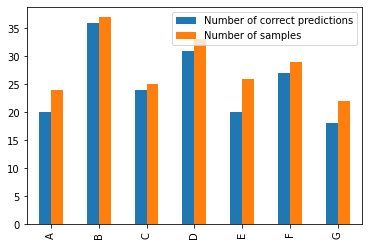

In [39]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [41]:
print(confusion_matrix(y_true, preds))

[[20  0  0  3  1  0  0]
 [ 0 36  0  0  0  1  0]
 [ 0  0 24  0  1  0  0]
 [ 2  0  0 31  0  0  0]
 [ 6  0  0  0 20  0  0]
 [ 0  1  1  0  0 27  0]
 [ 0  2  2  0  0  0 18]]


In [42]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.8979591836734694

In [43]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [44]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.71428571, 0.92307692, 0.88888889, 0.91176471, 0.90909091,
       0.96428571, 1.        ])

In [45]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.83333333, 0.97297297, 0.96      , 0.93939394, 0.76923077,
       0.93103448, 0.81818182])

In [46]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.76923077, 0.94736842, 0.92307692, 0.92537313, 0.83333333,
       0.94736842, 0.9       ])

In [47]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.714286,0.833333,0.769231
B,0.923077,0.972973,0.947368
C,0.888889,0.960000,0.923077
D,0.911765,0.939394,0.925373
E,0.909091,0.769231,0.833333
F,0.964286,0.931034,0.947368
G,1.000000,0.818182,0.900000


<AxesSubplot:>

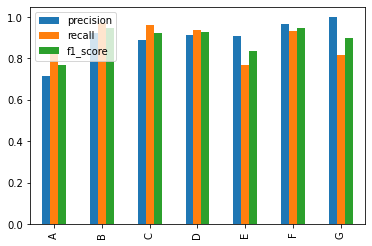

In [48]:
df.plot.bar()